In [318]:
import QUANTAXIS as QA
import jupyter_helper
import talib
import numpy as np
import pyecharts
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from talib import MA_Type

In [2]:
s,e=jupyter_helper.get_start_end_date()
benchmark_code=jupyter_helper.get_benchmark_code()
stock_code='601398'
DAYS=5#计算时间段

## 原始数据（不复权）

In [82]:
raw_data=QA.QA_fetch_stock_day_adv(stock_code,s,e)

In [83]:
qfq_data=raw_data.to_qfq().data.reset_index().set_index('date')#DataFrame格式

In [84]:
qfq_data.head(1)

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922


## 计算用原始数据

In [85]:
calc_data_raw=qfq_data.drop(columns=['code','preclose','adj'])#丢弃多余的列
calc_data_raw.head(1)

,open,high,low,close,volume,amount
date,,,,,,
2006-10-27,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09


## 计算用加工后数据

### 将原值中 volume ，amount 做归一化处理

In [86]:
# calc_data=calc_data_raw.pct_change()[1:]
calc_data=calc_data_raw.copy()
for column in ['amount','volume']:
    calc_data[[column]]=MinMaxScaler().fit_transform(calc_data[[column]])
calc_data.head(1)

,open,high,low,close,volume,amount
date,,,,,,
2006-10-27,1.992133,2.01557,1.910104,1.921823,1.0,0.52128


In [87]:
calc_data.describe()

,open,high,low,close,volume,amount
count,2948.000000,2948.000000,2948.000000,2948.000000,2948.000000,2948.000000
mean,3.554996,3.597808,3.516377,3.560160,0.052923,0.052411
std,1.002676,1.017516,0.990389,1.005053,0.067586,0.070880
min,1.915963,1.933541,1.888271,1.921823,0.000000,0.000000
25%,2.868193,2.891491,2.841474,2.869440,0.013480,0.011747
50%,3.077302,3.123482,3.043764,3.088881,0.029359,0.027901
75%,4.058404,4.089194,4.024172,4.060658,0.065786,0.065821
max,7.276664,7.439432,7.142620,7.420283,1.000000,1.000000


## 获取计算用数据的方法定义

In [152]:
def get_calc_data(stock_code,s,e,drop_columns=['code','preclose','adj'],minmaxscaler=['amount','volume']):
    raw_data=QA.QA_fetch_stock_day_adv(stock_code,s,e)
    qfq_data=raw_data.to_qfq().data.reset_index().set_index('date')#DataFrame格式
    calc_data=qfq_data.copy()
    if drop_columns:
        calc_data=calc_data.drop(columns=drop_columns)#丢弃多余的列
    if minmaxscaler:
        calc_data[minmaxscaler]=MinMaxScaler().fit_transform(calc_data[minmaxscaler])
    return calc_data

## 计算方法定义

In [382]:
def create_validate_df(df,days)->pd.DataFrame:
    '''根据 `df` 中的 high,low 列，制作新的数据。
    根据 `days` 指定的日期，选择 当前日期 之后的 `days`，分别选择其中最大，最小的 `high`,`low` 生成数据。
    '''
    result={}
    if 'high' not in df.columns or 'low' not in df.columns:
        raise ValueError('数据中不包含 high,low 列。')
    result=[]
    for i in range(len(calc_data.index)-days):
        result.append([calc_data[i+1:i+days].high.max(),
                     calc_data[i+1:i+days].high.min(),
                      calc_data[i+1:i+days].low.max(),
                     calc_data[i+1:i+days].low.min()])
    return pd.DataFrame(result,columns=['high_max','high_min','low_max','low_min'],index=calc_data.index[:-days])

def create_validate_df_1(df,days)->pd.DataFrame:
    '''根据 `df` 中的 close 列，制作新的数据。
    '''
    result={}
    if 'close' not in df.columns:
        raise ValueError('数据中不包含 close 列。')
    df_copy=df.copy()
    for i in range(1,days+1):
        df_copy[i]=df_copy.shift(i*-1).close
    return df_copy[[i for i in range(1,days+1)]].dropna()

def fit(df,days,test_size=0.1,func=ElasticNet,create_validate_func=create_validate_df_1):
    """
    Args:
        test_size: 测试集占比
    """
    y=create_validate_func(df,days)
    X=df[df.index.isin(y.index)]
#     y=np.round(y,4)
#     X=np.round(X,4)
    #定义测试
    shuffle = False  # 对于时间序列来说，不能把数据打乱
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=shuffle, test_size=test_size)
    X_train.shape,X_test.shape,y_train.shape,y_test.shape
    enet = func()
    fit=enet.fit(X_train, y_train)
    return fit,X_train, X_test, y_train, y_test

def get_prediction(f,days,df):
    test=f.predict(df)
    result=df['close'].reset_index().join(pd.DataFrame(test,columns=[i for i in range(1,days+1)])).set_index('date')
    return result
    return result['close'][1:].to_frame().reset_index().join(result.iloc[0].to_frame('prediction')).set_index('date')

# def report_prediction(f,days,df):
#     p=get_prediction(f,days,df)
#     pct_c=p.pct_change()
#     print(p.iloc[-1]/p.iloc[0]-1)
#     bar=pyecharts.Bar('原值与预测值')
#     bar.add("原值",p.index.date,p['close'])
#     bar.add('预测值',p.index.date,p['prediction'])
#     return p,pct_c,bar

## 得分

### RSI数据

In [195]:
calc_data=get_calc_data(stock_code,s,e)
calc_data['rsi']=talib.RSI(np.array(calc_data_raw.close),DAYS)
calc_data=calc_data.dropna()
calc_data[['rsi']]=MinMaxScaler().fit_transform(calc_data[['rsi']])
# calc_data

#### ElasticNet

In [196]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS)
f.score(X_test.dropna(),y_test.dropna())

-24.95956935375647

#### Lasso

In [197]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Lasso)
f.score(X_test.dropna(),y_test.dropna())

-26.831415085527684

#### Ridge

In [198]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Ridge)
f.score(X_test.dropna(),y_test.dropna())

0.8559345052345169

In [205]:
get_prediction(f,DAYS,calc_data[-DAYS:])

,close,prediction
date,,
2019-01-04,5.27,5.197616
2019-01-07,5.24,5.195257
2019-01-08,5.20,5.192693
2019-01-09,5.26,5.193046


### beta数据

In [187]:
calc_data=get_calc_data(stock_code,s,e)
calc_data['beta']=talib.BETA(np.array(calc_data_raw.high),np.array(calc_data_raw.low))
calc_data=calc_data.dropna()

#### ElasticNet

In [188]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS)
f.score(X_test,y_test)

-24.95956935375647

#### Lasso

In [189]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Lasso)
f.score(X_test,y_test)

-26.831415085527684

#### Ridge

In [190]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Ridge)
f.score(X_test,y_test)

0.8561810009252508

### MACD指标

In [191]:
calc_data=get_calc_data(stock_code,s,e,minmaxscaler=['open','high','low','close','volume','amount'])
calc_data['macd'], calc_data['macdsignal'], calc_data['macdhist'] = talib.MACDEXT(np.array(calc_data_raw.low),fastmatype=MA_Type.WMA,slowmatype=MA_Type.WMA,signalmatype=MA_Type.WMA)
calc_data=calc_data.dropna()

#### ElasticNet

In [192]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS)
f.score(X_test,y_test)

-26.24810791021557

#### Lasso

In [193]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Lasso)
f.score(X_test,y_test)

-26.24810791021557

#### Ridge

In [194]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Ridge)
f.score(X_test,y_test)

0.8484558064854796

#### SVR

In [295]:
# f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=SVR)
# f.score(X_test,y_test)

### 组合

In [355]:
DAYS=5
calc_data=get_calc_data(stock_code,s,e)

#动量	
#资金流量指数（MFI） 相对强弱指数（RSI） 随机振荡器 真实强度指数（TSI） 终极振荡器(ultosc) 威廉姆斯％R（％R）
calc_data['mfi']=talib.MFI(np.array(calc_data_raw.high),
                           np.array(calc_data_raw.low),
                           np.array(calc_data_raw.close),
                           np.array(calc_data_raw.volume),
                           DAYS)
calc_data['rsi']=talib.RSI(np.array(calc_data_raw.close),DAYS)
#https://en.wikipedia.org/wiki/Ultimate_oscillator
calc_data['ultosc']=talib.ULTOSC(np.array(calc_data_raw.high),
                           np.array(calc_data_raw.low),
                           np.array(calc_data_raw.close), 
                        timeperiod1=DAYS, timeperiod2=2*DAYS, timeperiod3=3*DAYS)
calc_data['wiilr']=talib.WILLR(np.array(calc_data_raw.high),
                           np.array(calc_data_raw.low),
                           np.array(calc_data_raw.close),
                           DAYS)

#移动平均
calc_data['dema']=talib.DEMA(np.array(calc_data_raw.close),DAYS)
calc_data['ema']=talib.EMA(np.array(calc_data_raw.close),DAYS)
calc_data['kama']=talib.KAMA(np.array(calc_data_raw.close),DAYS)
#mama, fama = MAMA(close, fastlimit=0, slowlimit=0)
calc_data['sma']=talib.SMA(np.array(calc_data_raw.close),DAYS)
calc_data['t3']=talib.T3(np.array(calc_data_raw.close),DAYS)
calc_data['tema']=talib.TEMA(np.array(calc_data_raw.close),DAYS)
calc_data['trima']=talib.TRIMA(np.array(calc_data_raw.close),DAYS)
calc_data['wma']=talib.WMA(np.array(calc_data_raw.close),DAYS)

calc_data['obv']=talib.OBV(np.array(calc_data_raw.close),np.array(calc_data_raw.volume))


calc_data['stddev']=talib.STDDEV(np.array(calc_data_raw.close),DAYS)
calc_data['tsf']=talib.TSF(np.array(calc_data_raw.close),DAYS)
calc_data['var']=talib.VAR(np.array(calc_data_raw.close),DAYS)

minmax_scaler_columns=['rsi','mfi','wiilr','ultosc','dema',
                       'ema','kama','sma','t3','tema','trima',
                       'wma','obv','tsf']

calc_data[minmax_scaler_columns]=MinMaxScaler().fit_transform(calc_data[minmax_scaler_columns])

calc_data=calc_data.dropna()

In [356]:
calc_data.describe()

,open,high,low,close,volume,amount,mfi,rsi,ultosc,wiilr,...,kama,sma,t3,tema,trima,wma,obv,stddev,tsf,var
count,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,...,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000
mean,3.567018,3.609879,3.528261,3.572114,0.052081,0.052147,0.536328,0.511160,0.533048,0.510135,...,0.316452,0.306167,0.278110,0.287263,0.304909,0.305335,0.649742,0.043430,0.301792,0.003527
std,0.997842,1.012796,0.985607,1.000346,0.065085,0.070569,0.265316,0.201442,0.153808,0.287159,...,0.192595,0.186091,0.192826,0.186529,0.185613,0.185621,0.222953,0.040520,0.176651,0.008420
min,1.966698,2.135617,1.888271,2.063223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.044644,0.037863,0.000000,0.000000,0.037165,0.036858,0.069726,0.002759,0.000000,0.000008
25%,2.874734,2.896649,2.846166,2.875958,0.013415,0.011713,0.342042,0.362066,0.426786,0.250000,...,0.184860,0.176934,0.144400,0.157321,0.175826,0.176260,0.572273,0.017061,0.179406,0.000291
50%,3.088801,3.132651,3.052488,3.095134,0.029055,0.027532,0.550118,0.500742,0.532953,0.500000,...,0.221103,0.216058,0.185096,0.198579,0.215873,0.215955,0.649224,0.030418,0.220161,0.000925
75%,4.060658,4.097325,4.029214,4.060852,0.064651,0.065446,0.735627,0.658127,0.636130,0.760217,...,0.411332,0.396309,0.372127,0.378970,0.395290,0.395324,0.851439,0.054911,0.390800,0.003015
max,7.276664,7.439432,7.142620,7.420283,0.805797,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.396761,1.000000,0.157419


In [357]:
f,X_train, X_test, y_train, y_test=fit(calc_data,DAYS,func=Ridge)
f.score(X_test.dropna(),y_test.dropna())

0.8581533485265771

In [373]:
# p,pct_c,plt=report_prediction(f,DAYS,calc_data[-DAYS:])

close        -0.001898
prediction   -0.001462
dtype: float64


In [384]:
report=get_prediction(f,DAYS,calc_data[-10:])

In [385]:
report

,close,1,2,3,4,5
date,,,,,,
2018-12-25,5.23,5.223274,5.217092,5.216261,5.217853,5.212778
2018-12-26,5.27,5.263017,5.258348,5.257126,5.257513,5.251325
2018-12-27,5.28,5.286290,5.285064,5.284784,5.278978,5.272758
2018-12-28,5.29,5.295060,5.292759,5.291902,5.285750,5.282352
2019-01-02,5.20,5.195364,5.194283,5.190974,5.186458,5.191740
2019-01-03,5.20,5.191160,5.186556,5.182065,5.183569,5.184623
2019-01-04,5.27,5.251548,5.246717,5.246321,5.253859,5.253062
2019-01-07,5.24,5.242463,5.243610,5.243456,5.240528,5.240788
2019-01-08,5.20,5.199115,5.198444,5.195560,5.193920,5.193905


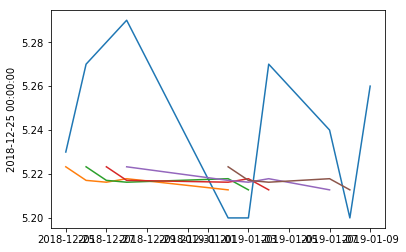

In [394]:
sns.lineplot(x=report.index.date,y=report.close)
for i in range(len(report.index)-DAYS):
    sns.lineplot(x=report.index[i:DAYS+i].date,y=report.iloc[0][[1,2,3,4,5]])

In [413]:
for i in range(len(report.index)-DAYS):
    line=pyecharts.Line('')
    line.add('真实值',report.index[i:DAYS+i].date,report.iloc[i:DAYS+i]['close'])
    columns=[i for i in range(1,DAYS+1)]
    line.add('预测值',report.index[i:DAYS+i].date,report.iloc[0][columns])
    line.render()